# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified stochastic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices()
levels = initN.size

### Initialize the model

In [3]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': 10*np.ones(levels)}

In [4]:
model = models.COVID19_SEIRD_sto(initial_states, params, discrete=True)

### Scrape high-level Sciensano data

In [5]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-10-01,771,156,87,67,867,15,0.0,2.0,3.0,5,5.0
2020-10-02,789,163,66,50,883,11,0.0,0.0,2.0,6,3.0
2020-10-03,819,185,73,74,882,13,0.0,0.0,4.0,4,5.0
2020-10-04,866,186,86,34,934,14,0.0,0.0,1.0,5,8.0
2020-10-05,937,195,87,33,988,3,0.0,1.0,0.0,2,0.0


### Calibrating $\beta$ and lag_time

**Go to next section if posterior samples are available**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

In [6]:
# define dataset
data=[df_sciensano["H_in"].values[:8]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(20,80),(0.01,0.08)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=100,popsize=100)

No constraints given.
New best for swarm at iteration 1: [6.30142951e+01 4.70580180e+01 3.82450398e-02] 35.79660987251463
Best after iteration 1: [6.30142951e+01 4.70580180e+01 3.82450398e-02] 35.79660987251463
New best for swarm at iteration 2: [46.88303544 37.25105515  0.05222563] 33.32922327973213
Best after iteration 2: [46.88303544 37.25105515  0.05222563] 33.32922327973213
Best after iteration 3: [46.88303544 37.25105515  0.05222563] 33.32922327973213
New best for swarm at iteration 4: [39.30661162 40.13732987  0.04673782] 32.84069938129848
Best after iteration 4: [39.30661162 40.13732987  0.04673782] 32.84069938129848
Best after iteration 5: [39.30661162 40.13732987  0.04673782] 32.84069938129848
Best after iteration 6: [39.30661162 40.13732987  0.04673782] 32.84069938129848
Best after iteration 7: [39.30661162 40.13732987  0.04673782] 32.84069938129848
Best after iteration 8: [39.30661162 40.13732987  0.04673782] 32.84069938129848
Best after iteration 9: [39.30661162 40.1373298

Best after iteration 90: [32.11047953 40.21507052  0.04680185] 29.91574930810199
Best after iteration 91: [32.11047953 40.21507052  0.04680185] 29.91574930810199
Best after iteration 92: [32.11047953 40.21507052  0.04680185] 29.91574930810199
Best after iteration 93: [32.11047953 40.21507052  0.04680185] 29.91574930810199
Best after iteration 94: [32.11047953 40.21507052  0.04680185] 29.91574930810199
New best for swarm at iteration 95: [32.46235835 40.45590984  0.04668972] 29.891314295764126
Best after iteration 95: [32.46235835 40.45590984  0.04668972] 29.891314295764126
Best after iteration 96: [32.46235835 40.45590984  0.04668972] 29.891314295764126
Best after iteration 97: [32.46235835 40.45590984  0.04668972] 29.891314295764126
Best after iteration 98: [32.46235835 40.45590984  0.04668972] 29.891314295764126
Best after iteration 99: [32.46235835 40.45590984  0.04668972] 29.891314295764126
Best after iteration 100: [32.46235835 40.45590984  0.04668972] 29.891314295764126
Stopping 

In [7]:
lag_time = int(round(theta[1]))
# Assign 'extraTime' or lag_time as a model attribute --> is needed to perform the optimalization
model.extraTime = int(round(theta[1]))
# Date of first data collection
start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [8]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))
# Initialise starting position of sampler based on PSO estimate
pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [32:05<00:00,  2.60it/s]


In [9]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

In [10]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

The chain is shorter than 50 times the integrated autocorrelation time.


In [11]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 1 = beta
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

0.046606841040937 0.045010979983765 0.04815811259508416


Initialize a dictionary with the posterior samples and write them to `parameters_deterministic.json`

In [12]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [13]:
with open('../data/interim/model_parameters/stochastic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make a traceplot and cornerplot of the posterior samples

<AxesSubplot:xlabel='step number', ylabel='beta'>

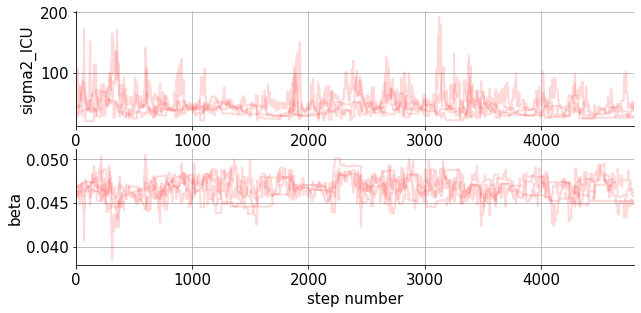

In [14]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-15-c18ce7300ecb>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_stochastic/corner_beta.pdf', dpi=600, bbox_inches='tight',


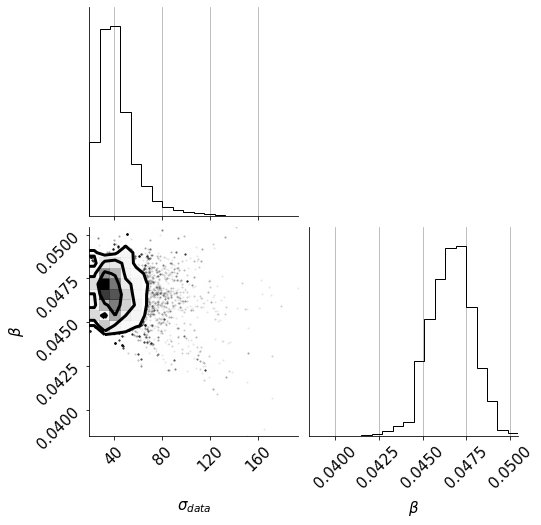

In [15]:
fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta$']
);
fig.set_size_inches(8, 8)
plt.savefig('../results/calibration_non_spatial_stochastic/corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

Make a visualisation of the data and model prediction

<ipython-input-16-7c2dac47b531>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_stochastic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


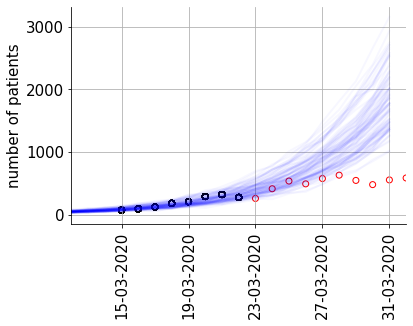

In [16]:
T = 9
fig,ax=plt.subplots()

for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.03})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
plt.savefig('../results/calibration_non_spatial_stochastic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance ramp parameters

Load the previously calibrated parameters.

In [17]:
# Load previous samples
with open('../data/interim/model_parameters/stochastic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

Find an initial guess for the MCMC sampler by using PSO

In [18]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

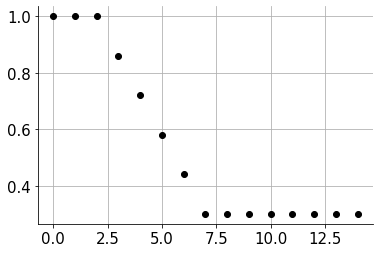

In [19]:
t = np.linspace(0,14,15)
policy1=1
policy2=0.6
prevention=0.5
policy_time=0
l = 5
tau = 2
for time in t:
    plt.plot(time,lockdown_func(time,1,policy_time,policy1,policy2,l,tau,prevention),'o',color='black')

In [20]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': 10*np.ones(levels)}

In [21]:
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

In [22]:
model = models.COVID19_SEIRD_sto(initial_states, params, time_dependent_parameters={'Nc':lockdown_func}, discrete=True)

In [23]:
lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [24]:
samples_beta = {'beta': samples_dict['beta']}

In [25]:
# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,600),(0.1,20),(0.1,20),(0.1,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=samples_beta,maxiter=100,popsize=100)

No constraints given.
New best for swarm at iteration 1: [1.41625180e+02 6.49200816e+00 1.00000000e-01 1.00000000e-01] 195.37049642783285
Best after iteration 1: [1.41625180e+02 6.49200816e+00 1.00000000e-01 1.00000000e-01] 195.37049642783285
Best after iteration 2: [1.41625180e+02 6.49200816e+00 1.00000000e-01 1.00000000e-01] 195.37049642783285
New best for swarm at iteration 3: [90.87592362  8.07728264  0.1         0.1       ] 184.84910241274633
Best after iteration 3: [90.87592362  8.07728264  0.1         0.1       ] 184.84910241274633
New best for swarm at iteration 4: [74.72834216  8.29164956  0.1         0.11785398] 179.13279430793816
Best after iteration 4: [74.72834216  8.29164956  0.1         0.11785398] 179.13279430793816
Best after iteration 5: [74.72834216  8.29164956  0.1         0.11785398] 179.13279430793816
New best for swarm at iteration 6: [68.43930206  8.31087636  0.1         0.1       ] 178.9690150411828
Best after iteration 6: [68.43930206  8.31087636  0.1         

Best after iteration 68: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 69: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 70: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 71: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 72: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 73: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 74: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 75: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 76: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 77: [53.26200934  5.71586201  0.1         0.22602247] 163.90654897158623
Best after iteration 78: [53.26200934  5.71586201  0.1      

In [26]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2],
    'prevention' : theta[3]
}
)

Initialize and run the MCMC sampler

In [27]:
bounds=((1,600),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.01, 0.01, 0.01 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,samples_beta))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [1:37:34<00:00,  1.17s/it]


In [28]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

The chain is shorter than 50 times the integrated autocorrelation time.


In [29]:
samples = sampler.get_chain(discard=0,flat=False)
flat_samples = sampler.get_chain(discard=0,flat=True)

Append posterior samples to the samples dictionary

In [30]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [31]:
with open('../data/interim/model_parameters/stochastic_'+ datetime.datetime.today().strftime('%Y-%m-%d') + '.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [32]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 0 --> sigma_{data}
# index 3 --> prevention
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

3.827826610039953 1.1138326323446497 5.76243137828007


<AxesSubplot:xlabel='step number', ylabel='prevention'>

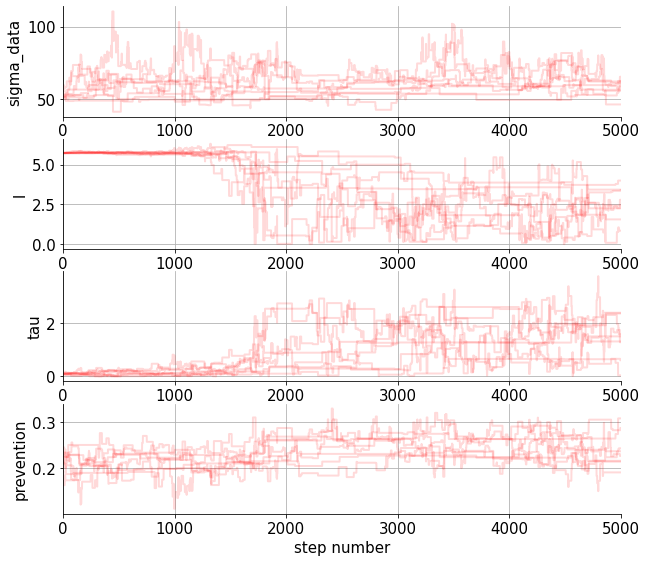

In [33]:
traceplot(samples=sampler.get_chain(discard=0),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-34-d0c0327820fc>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_stochastic/corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',


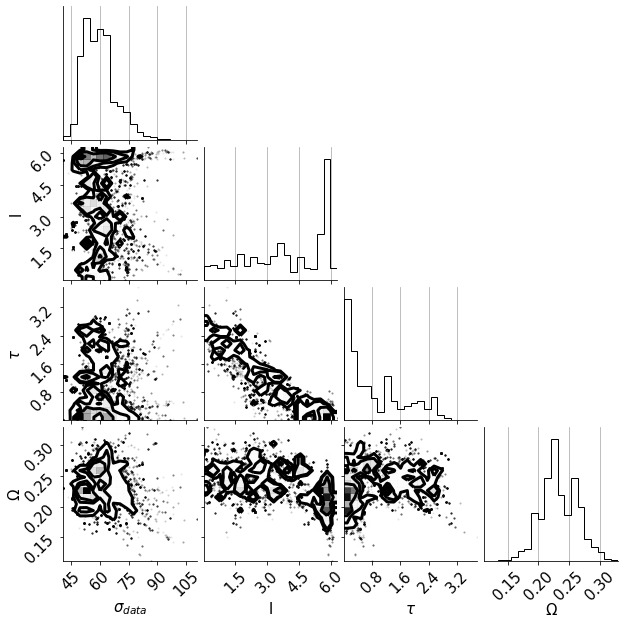

In [34]:
fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('../results/calibration_non_spatial_stochastic/corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

<ipython-input-35-05fa854a3333>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_stochastic/plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


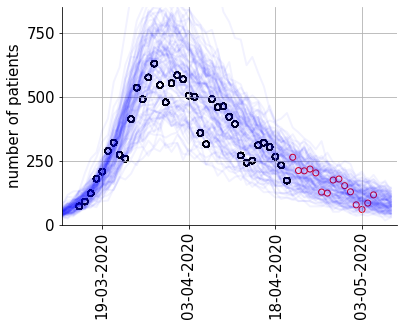

In [35]:
T = 18
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(100):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(flat_samples[:,1])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:52].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:52], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
plt.savefig('../results/calibration_non_spatial_stochastic/plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Computation of the basic reproduction number

3.597988163249603 3.4747897428964083 3.7177443313388503


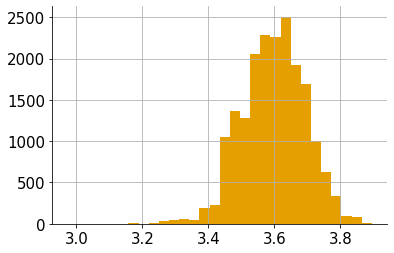

In [36]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

2.0436109651942087 1.9736358481829837 2.111630927226488
2.781704904654076 2.6864567730336 2.8742917351331316
5.393456404706868 5.208779502183771 5.572973302061179
6.238754749056408 6.025134054606831 6.446406728022565
5.151665732819205 4.975267965046177 5.3231348203889395
3.751413128995718 3.6229612968565346 3.8762759247761434
2.054539787858415 1.9841904579183371 2.1229235070418047
1.1839422087201164 1.1434029397493 1.2233487814275115
0.9968175684881231 0.9626856191191919 1.0299958467007901


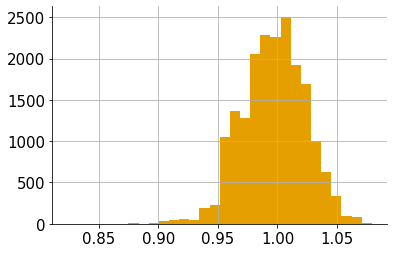

In [37]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

### Visualisations used in the preprint